In [1]:
import cv2
import numpy as np
import glob
import seaborn as sns
from sklearn.ensemble import IsolationForest
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math

Questa funzione prende in ingresso l'immagine originale, l'immagine ritagliata e il nome del salvataggio. Restituisce un immagine che rappresenta la zona di lavoro

In [2]:
def cutWorkSpace(img,border): 
    # dimensioni immagini
    img_h = 2048
    img_l = 2048
    # offset per posizionamento su area d'indagine
    offset_x = 600
    offset_y = 500
    
    #taglio per garantire la ricerca sull'area di interesse, evitando rumori dati dallo sfondo
    crop_img = img[offset_y:img_h-offset_y, offset_x:img_l-offset_x]
    
    # Convert the img to grayscale
    gray = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #cv2.imwrite('provaT.jpg', thresh_im)
    lowThresh = 0.5*high_thresh
    
    
    # Apply edge detection method on the image
    #edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    #cv2.imwrite('results_img/'+str(count_img)+'ed.jpg', edges)
    #cv2.imwrite('canny.jpg', edges)
    # This returns an array of r and theta values
    lines = cv2.HoughLines(edges,1,np.pi/180, 100)
    #cv2.imwrite('Risultati/resFS'+name+'c.jpg', edges)
    # The below for loop runs till r and theta values 
    # are in the range of the 2d array
    i = 0
    x_first = 0
    x_second = 0
    count = 0
    delta = 30
    thetaFinal = 0
    while count < 2:
        for r,theta in lines[i]:
            # Stores the value of cos(theta) in a
            a = np.cos(theta)

            # Stores the value of sin(theta) in b
            b = np.sin(theta)

            # x0 stores the value rcos(theta)
            x0 = a*r

            # y0 stores the value rsin(theta)
            y0 = b*r

            #ti define line lenght
            const = 3000
            # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
            x1 = int(x0 + const*(-b))

            # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
            y1 = int(y0 + const*(a))

            # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
            x2 = int(x0 - const*(-b))

            # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
            y2 = int(y0 - const*(a))

            if count == 0 :
                if theta != 0:
                    thetaFinal = 180-math.degrees(theta)
                x_first = x0
                #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                count += 1
            else:
                if abs(x_first-x0) > delta :
                    x_second = x0
                    #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                    count += 1
            i += 1
    # All the changes made in the input image are finally
    # written on a new image houghlines.jpg
    #cv2.imwrite('Risultati/res'+name+'.jpg', img)
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # rotate our image by Theta degrees around the center of the image
    M = cv2.getRotationMatrix2D((cX, cY), -thetaFinal, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    scale_percent = 100 # percent of original size

  
    if x_first < x_second:
        
        median = (x_second+x_first)//2
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)        
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    else:
        median = (x_first+x_second)//2.
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]        
        #blurred = cv2.GaussianBlur(temp, (3,3), 0)
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    

In [3]:
def divideImage(img,lung):
    results = []
    
    for i in range(2048// lung):
        results.append(img[(lung*i):(lung*(i+1))][:])

    return results

In [4]:
def create_PCA(image_arrays,components):
    
    x = image_arrays

    scaler.fit(x)
    x = scaler.transform(x)

    pca = PCA(n_components=components)
    principalComponents = pca.fit_transform(x)

    return principalComponents, pca

In [5]:
def use_PCA(image_arrays,pca):
    
    x = image_arrays

    x = scaler.transform(x)

    principalComponents = pca.transform(x)

    return principalComponents

In [6]:
## creazione array da immagine
def createNN(imgsWithClass):
    
    # creo histogramma con valori trovati di feature per ogni immagine di train
    train_imgs = imgsWithClass[0]
    res = []
    k = 0
    for img in train_imgs:
        im = []
        for d in img:
            for i in d:
                im.append(i)
        im.append(imgsWithClass[1][k])
        k += 1
        res.append(im)
    
    res = np.array(res)
    
    
    ####################################################################
    ###  Qua devo usare la PCA creata per ridurre la dimensionalità  ###
    ####################################################################
    
    
    
    return res
    #return kmeans, mlp, val_result

In [7]:
## creazione array da immagine
def createNN_2(imgsWithClass):
    
    # creo histogramma con valori trovati di feature per ogni immagine di train
    train_imgs = imgsWithClass
    res = []
    k = 0
    for img in train_imgs:
        im = []
        for d in img:
            for i in d:
                im.append(i)
        k += 1
        res.append(im)
    
    res = np.array(res)
    
    
    ####################################################################
    ###  Qua devo usare la PCA creata per ridurre la dimensionalità  ###
    ####################################################################
    
    
    
    return res
    #return kmeans, mlp, val_result

In [8]:
## data un'immagine creo l'array e fitto il modello 

def testNN(train_imgs):
    
    results=[]
    
    res = []
    for img in train_imgs:
        im = []
        for d in img:
            for i in d:
                im.append(i)
        res.append(im)
    
    res = np.array(res)
    
    ####################################################################
    ###  Qua devo usare la PCA creata per ridurre la dimensionalità  ###
    ####################################################################
    
    cols = []
        
    for i in range(len(res[0])):
        cols.append('F'+str(i+1))


    df = pd.DataFrame(res ,columns = cols)
    results.append(model.predict(df[cols]))

    return results

In [9]:
def scale_image(img,scale_percent):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)    

85
11447
0.0074255263387787195


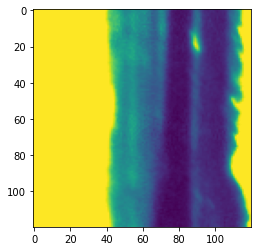

In [10]:
count_img = 0 
scelta = 120
threshold = 5
if scelta == 70:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni70/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni70Val/*.tif'
    contamination_N = 6/79.

if scelta == 100:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni100/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni100Val/*.tif'
    contamination_N = 6/107.
if scelta == 120:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120Val/*.tif'
    contamination_N = 6/126.

pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/Dataset/SectionScarti/*.tif'

pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'



scaler = StandardScaler() 

lunghezza_sezione_immagine = 120
border = 60
Nclusters = 10
reduction = 30
pca_components_number = 1000
#
#
pezziXimmagine = 2048 // lunghezza_sezione_immagine

results = []
img_results = []
list_paths = []

list_paths_scarti = glob.glob(pathScarti)
results += [1] * len(glob.glob(pathScarti))

temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'

#temp = '/Users/leonardoaggio/Desktop/Dataset/Dataset/Cam3@00004v2/*.tif'
pathBuoni = temp

list_paths = glob.glob(pathBuoni) 
#results += [0] * len(glob.glob(pathBuoni)) * pezziXimmagine

#temp = '/Users/leonardoaggio/Desktop/Dataset/Dataset/Cam3@00004v1/*.tif'
#pathBuoni = temp

list_paths += glob.glob(pathBuoni) 
results += [0] * len(list_paths) * pezziXimmagine


#list_paths += glob.glob(pathFS)
#results += [0] * len(glob.glob(pathFS)) * pezziXimmagine


#list_paths += glob.glob(pathBuoniVal) 
#results += [0] * len(glob.glob(pathBuoniVal)) * pezziXimmagine

#list_paths += glob.glob(pathFSVal)
#results += [0] * len(glob.glob(pathFSVal)) * pezziXimmagine

#list_paths += glob.glob(pathScartiVal)
#results += [1] * len(glob.glob(pathScartiVal)) * pezziXimmagine



for img_path in list_paths_scarti:
    img = cv2.imread(img_path)
    #plt.imshow(img)
    #plt.show()
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #plt.imshow(img)
    #plt.show()
    img_results.append(img)
    
    
    
imgs_for_PCA = []
#print(results)
i = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    #print(img_path)
    cv2.imwrite('results_img/'+str(count_img)+'im.jpg', img)
    temp = cutWorkSpace(img,border)
    #cv2.imwrite('ImgScarte/img'+str(i)+'.jpg', temp)
    temp2 = divideImage(temp,lunghezza_sezione_immagine)[2:15]
    img_results += temp2
    imgs_for_PCA += temp2
    #j = 0
    #for im in temp2:
    cv2.imwrite('results_img/'+str(count_img)+'.jpg', temp)
    #j += 1
    i += 1
    count_img += 1
    
contamination_N = (len(list_paths_scarti)) / (len(img_results) )

print(len(list_paths_scarti))
print(len(img_results))

print(contamination_N)
    
plt.imshow(img_results[1])
plt.show()

In [11]:
## creazione PCA

temp = []

for img in imgs_for_PCA:
    temp.append(scale_image(img,reduction))
    
imgs_for_PCA = temp

    
array_PCA = np.array(imgs_for_PCA)
array_PCA = array_PCA/255.



In [12]:
array_PCA = createNN_2(array_PCA)


principalComponents, pca = create_PCA(array_PCA,pca_components_number)



In [13]:
temp = []

for img in img_results:
    temp.append(scale_image(img,reduction))
    

In [14]:
img_results = temp

In [15]:
train_images = np.array(img_results)
train_images = train_images/255.

In [16]:
imgsWithClass = [train_images,results]


histo_t = createNN_2(imgsWithClass[0])

histo = use_PCA(histo_t,pca)

In [17]:
import pandas as pd

print(Nclusters)
cols = []
hist_2 = []
i = 0




for i in range(len(histo[0])):
    cols.append('F'+str(i+1))


df = pd.DataFrame(histo ,columns = cols)



10


In [18]:
df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F991,F992,F993,F994,F995,F996,F997,F998,F999,F1000
0,-42.317661,16.577102,63.733101,55.092567,88.090103,-8.039257,-62.006220,-23.908929,17.547451,-11.019481,...,-0.644856,0.059263,0.497189,-0.034240,-2.929207,0.414923,-0.393664,-0.364709,0.570158,-0.440085
1,-39.508067,12.958090,62.479286,51.502529,77.805464,-14.464019,-62.841642,-33.786823,19.118852,-10.460211,...,-0.057125,-0.507614,0.579776,-0.469297,0.965948,0.398790,0.124904,-0.145556,-0.606641,-0.563254
2,21.644606,37.467033,-14.534992,4.952378,5.299328,-9.829715,-5.433735,5.149838,-1.073696,-6.651047,...,0.090045,-0.021652,-0.019159,-0.136116,0.060731,0.005019,-0.064709,0.003112,0.071250,-0.021274
3,16.446622,30.223277,-16.323956,-1.870067,11.220427,-18.564181,-6.368113,10.808991,4.769961,-9.011410,...,-0.033577,-0.085862,-0.147830,-0.102552,-0.001834,-0.051999,-0.045873,-0.065911,-0.011204,0.023852
4,-35.890404,18.202195,47.265422,49.128848,74.493511,-15.451059,-52.758345,-21.336826,18.468478,-14.449773,...,-0.714950,-0.155491,0.093637,0.634921,-1.350414,0.993439,-1.604878,0.601695,-0.788803,0.460018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11442,7.013129,-20.131176,18.944235,-11.698105,-2.881930,-4.790784,1.851540,9.311002,-1.390797,-1.543393,...,-0.013086,-0.018105,0.014140,-0.001301,0.025584,0.015731,-0.014681,-0.022123,0.006847,-0.009522
11443,11.967646,-21.010865,15.838629,-10.559510,-2.875587,-0.610012,-1.117757,9.612733,1.926156,-3.361205,...,0.028641,-0.018250,-0.002324,0.023725,-0.023553,-0.003682,-0.003824,0.012919,0.018787,0.025715
11444,13.324117,-19.272339,9.923516,-9.149098,-0.282018,0.849899,-2.921104,4.343237,2.640952,2.248754,...,0.056384,0.009897,-0.002972,-0.015800,-0.000572,0.014014,-0.015400,0.011383,0.004406,0.003195
11445,16.095886,-19.051665,2.681356,-9.566883,1.414558,8.352005,-6.918411,1.028337,3.933300,-2.312995,...,0.007785,-0.000467,-0.015718,-0.009102,-0.025038,-0.019227,0.011528,0.015067,0.018001,-0.078175


In [19]:
#sns.boxplot(histo[0])

In [20]:
random_state = np.random.RandomState(42)

In [21]:
col = []

for i in range(len(histo[0])):
    col.append('F'+str(i+1))

model=IsolationForest(n_estimators=100,verbose = 1,max_samples='auto',contamination=contamination_N,random_state=random_state)

model.fit(histo)

print(model.get_params())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s finished


{'bootstrap': False, 'contamination': 0.0074255263387787195, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': RandomState(MT19937) at 0x7FB9103C1D10, 'verbose': 1, 'warm_start': False}


In [22]:
df['scores'] = model.decision_function(df[col])

df['anomaly_score'] = model.predict(df[col])

df[df['anomaly_score']==-1]

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F993,F994,F995,F996,F997,F998,F999,F1000,scores,anomaly_score
0,-42.317661,16.577102,63.733101,55.092567,88.090103,-8.039257,-62.006220,-23.908929,17.547451,-11.019481,...,0.497189,-0.034240,-2.929207,0.414923,-0.393664,-0.364709,0.570158,-0.440085,-0.206520,-1
1,-39.508067,12.958090,62.479286,51.502529,77.805464,-14.464019,-62.841642,-33.786823,19.118852,-10.460211,...,0.579776,-0.469297,0.965948,0.398790,0.124904,-0.145556,-0.606641,-0.563254,-0.209407,-1
4,-35.890404,18.202195,47.265422,49.128848,74.493511,-15.451059,-52.758345,-21.336826,18.468478,-14.449773,...,0.093637,0.634921,-1.350414,0.993439,-1.604878,0.601695,-0.788803,0.460018,-0.181683,-1
7,-39.696805,18.557425,43.898119,34.561709,51.575760,-19.653822,-63.322341,-24.837850,15.251116,-8.853450,...,0.960006,-0.070660,0.124232,0.296078,0.343351,-0.106963,-0.582423,-0.347335,-0.207588,-1
8,-41.536953,17.437993,48.117190,34.412147,45.166373,-20.633067,-68.096819,-29.246634,17.509948,-9.991841,...,-0.472672,0.334783,-0.944285,-0.128295,-0.718547,-0.771972,0.543287,-0.479532,-0.159002,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8883,-13.454890,-9.685503,23.027963,5.722355,-2.514309,1.771895,10.091522,-2.656716,-1.871699,0.344861,...,0.012596,0.008903,-0.019519,-0.009282,0.008320,-0.015815,-0.009166,0.002306,-0.025110,-1
8884,-10.640556,-9.235487,15.679162,7.953433,1.446787,-0.714920,14.903656,-13.262594,5.482255,0.534124,...,0.038742,-0.029813,0.084865,0.027401,0.055792,0.025853,-0.054348,-0.005958,-0.006147,-1
9079,-23.153607,4.127447,21.539342,-4.889138,-4.866094,2.029264,-2.080825,1.698251,3.524454,-1.191955,...,-0.035118,0.067851,-0.054677,-0.146775,0.091554,0.077345,0.014967,-0.000592,-0.002845,-1
9379,9.283220,8.045157,4.378994,12.262712,-3.244577,4.462294,-25.319124,12.447120,5.849099,-5.282843,...,0.043795,0.011479,0.001157,0.031463,0.016530,-0.001931,0.017391,0.008461,-0.018409,-1


In [23]:
df

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F993,F994,F995,F996,F997,F998,F999,F1000,scores,anomaly_score
0,-42.317661,16.577102,63.733101,55.092567,88.090103,-8.039257,-62.006220,-23.908929,17.547451,-11.019481,...,0.497189,-0.034240,-2.929207,0.414923,-0.393664,-0.364709,0.570158,-0.440085,-0.206520,-1
1,-39.508067,12.958090,62.479286,51.502529,77.805464,-14.464019,-62.841642,-33.786823,19.118852,-10.460211,...,0.579776,-0.469297,0.965948,0.398790,0.124904,-0.145556,-0.606641,-0.563254,-0.209407,-1
2,21.644606,37.467033,-14.534992,4.952378,5.299328,-9.829715,-5.433735,5.149838,-1.073696,-6.651047,...,-0.019159,-0.136116,0.060731,0.005019,-0.064709,0.003112,0.071250,-0.021274,0.045357,1
3,16.446622,30.223277,-16.323956,-1.870067,11.220427,-18.564181,-6.368113,10.808991,4.769961,-9.011410,...,-0.147830,-0.102552,-0.001834,-0.051999,-0.045873,-0.065911,-0.011204,0.023852,0.078898,1
4,-35.890404,18.202195,47.265422,49.128848,74.493511,-15.451059,-52.758345,-21.336826,18.468478,-14.449773,...,0.093637,0.634921,-1.350414,0.993439,-1.604878,0.601695,-0.788803,0.460018,-0.181683,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11442,7.013129,-20.131176,18.944235,-11.698105,-2.881930,-4.790784,1.851540,9.311002,-1.390797,-1.543393,...,0.014140,-0.001301,0.025584,0.015731,-0.014681,-0.022123,0.006847,-0.009522,0.136032,1
11443,11.967646,-21.010865,15.838629,-10.559510,-2.875587,-0.610012,-1.117757,9.612733,1.926156,-3.361205,...,-0.002324,0.023725,-0.023553,-0.003682,-0.003824,0.012919,0.018787,0.025715,0.147448,1
11444,13.324117,-19.272339,9.923516,-9.149098,-0.282018,0.849899,-2.921104,4.343237,2.640952,2.248754,...,-0.002972,-0.015800,-0.000572,0.014014,-0.015400,0.011383,0.004406,0.003195,0.127428,1
11445,16.095886,-19.051665,2.681356,-9.566883,1.414558,8.352005,-6.918411,1.028337,3.933300,-2.312995,...,-0.015718,-0.009102,-0.025038,-0.019227,0.011528,0.015067,0.018001,-0.078175,0.139584,1


In [24]:
threshold = 1

In [25]:
temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
#temp = pathScarti
test_path = glob.glob(temp) 
results = []
i = 0
res = []
img_results = []

for img_path in test_path:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    temp2 = divideImage(temp,lunghezza_sezione_immagine)[2:15]
    
    
    temp3 = []

    for img_s in temp2:
        temp3.append(scale_image(img_s,reduction))
        
    img_results = temp3
    
    
    train_images = np.array(img_results)
    train_images = train_images/255.
    
    res_2 = createNN_2(train_images)
        
    histo = use_PCA(res_2,pca)
    
    res = [model.predict(histo)]
    
    scarto = 0
    
    
    for el in res:
        for e in el:
            if e == -1:
                scarto += 1
    if scarto < threshold:
        i +=1
    print(img_path)
        
    print(res)
    print(scarto)
print('TRAIN scarti')
print('BUONI : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 8.tif
[array([-1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
4
/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 9.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1])]
3
/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 2.tif
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 3.tif
[array([-1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
1
/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 4.tif
[array([-1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1])]
5
/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 5.tif
[array([ 1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
1
/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 7.tif
[array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1])]
12
/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTota

In [26]:
temp = pathScartiVal
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
#temp = pathScarti
test_path = glob.glob(temp) 
results = []
i = 0
res = []
img_results = []

for img_path in test_path:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    temp2 = divideImage(temp,lunghezza_sezione_immagine)[2:15]
    
    
    temp3 = []

    for img_s in temp2:
        temp3.append(scale_image(img_s,reduction))
        
    img_results = temp3
    
    
    train_images = np.array(img_results)
    train_images = train_images/255.
    
    res_2 = createNN_2(train_images)
        
    histo = use_PCA(res_2,pca)
    
    res = [model.predict(histo)]
    
    scarto = 0
    
    
    for el in res:
        for e in el:
            if e == -1:
                scarto += 1
    if scarto < threshold:
        i +=1
    print(img_path)
        
    print(res)
    print(scarto)
print('TRAIN scarti')
print('BUONI : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/Cam3@00004 8.tif
[array([-1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1])]
4
/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/Cam3@00004 9.tif
[array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1])]
3
/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/Cam3@00004 10.tif
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
0
TRAIN scarti
BUONI : 1
Falsi buoni su scarti totali: 0.3333333333333333


In [27]:
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'


temp = pathBuoniVal
test_path = glob.glob(temp) 
results = []
i = 0
res = []
img_results = []

for img_path in test_path:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    temp2 = divideImage(temp,lunghezza_sezione_immagine)[2:15]
    
    
    temp3 = []

    for img_s in temp2:
        temp3.append(scale_image(img_s,reduction))
        
    img_results = temp3
    
    
    train_images = np.array(img_results)
    train_images = train_images/255.
    
    res_2 = createNN_2(train_images)
        
    histo = use_PCA(res_2,pca)
    
    res = [model.predict(histo)]
    
    scarto = 0
    
    
    for el in res:
        for e in el:
            if e == -1:
                scarto += 1
    if scarto >= threshold:
        i +=1
    #print(img_path)
        
    #print(res)
    print(scarto)
print('Buoni validation')
print('Scarti : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Buoni validation
Scarti : 2
Falsi buoni su scarti totali: 0.02531645569620253


[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1,

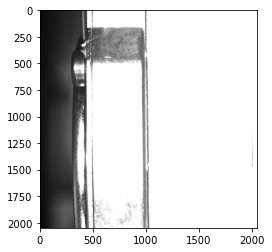

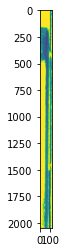

/Users/leonardoaggio/Desktop/Dataset/Dataset/Cam3@00004v2/61914943830747.tif
[array([-1,  1,  1,  1,  1,  1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1])]
0


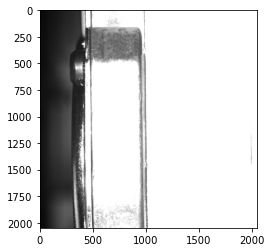

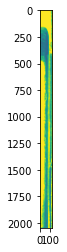

/Users/leonardoaggio/Desktop/Dataset/Dataset/Cam3@00004v2/72114874942046.tif
[array([-1,  1,  1,  1,  1,  1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0


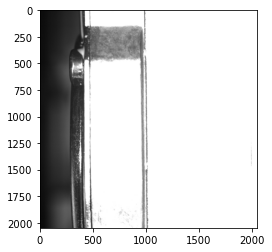

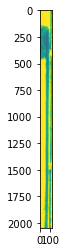

/Users/leonardoaggio/Desktop/Dataset/Dataset/Cam3@00004v2/61914943830800.tif
[array([-1,  1,  1,  1,  1,  1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0


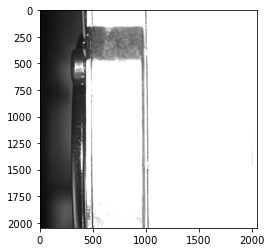

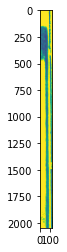

/Users/leonardoaggio/Desktop/Dataset/Dataset/Cam3@00004v2/61914943830815.tif
[array([ 1,  1,  1,  1,  1,  1, -1])]
1
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1,

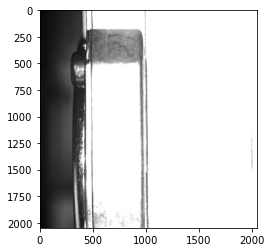

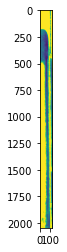

/Users/leonardoaggio/Desktop/Dataset/Dataset/Cam3@00004v2/72114874942586.tif
[array([-1,  1,  1,  1,  1,  1,  1])]
1
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1, 1])]
0
[array([1, 1, 1, 1, 1, 1,

In [31]:
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
temp = '/Users/leonardoaggio/Desktop/Dataset/Dataset/Cam3@00004v2/*.tif'




test_path = glob.glob(temp) 
results = []
i = 0
res = []
img_results = []

for img_path in test_path:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    temp2 = divideImage(temp,lunghezza_sezione_immagine)[5:12]
    
    
    temp3 = []

    for img_s in temp2:
        temp3.append(scale_image(img_s,reduction))
        
    img_results = temp3
    
    
    train_images = np.array(img_results)
    train_images = train_images/255.
    
    res_2 = createNN_2(train_images)
        
    histo = use_PCA(res_2,pca)
    
    res = [model.predict(histo)]
    
    scarto = 0
    
    
    for el in res:
        for e in el:
            if e == -1:
                scarto += 1
    if scarto >= threshold:
        i +=1
        plt.imshow(img)
        plt.show()
        plt.imshow(temp)
        plt.show()
        print(img_path)
        
    print(res)
    print(scarto)


In [32]:
print(len(test_path))

436


In [33]:
print('TRAIN Buoni')
print('Scarti : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

TRAIN Buoni
Scarti : 5
Falsi buoni su scarti totali: 0.011467889908256881
